In [18]:
from time import time
import numpy as np
import pandas as pd
import scipy
from scipy import signal
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import seaborn as sns
import pyriemann
from pyriemann.classification import MDM
from pyriemann.utils.covariance import covariances
import pickle
from sklearn.model_selection import LeaveOneOut,cross_val_predict
import warnings
warnings.filterwarnings("ignore")

In [19]:
class Processing:

    def __int__(self):
        return self

    def extendSignal(self,sig, fs,target_freqs, type):
        """Applies a filter bank and extend signal
        Args:
            signal: EEG signal with the shape: (N_chan, N_sample)
            target_freqs: list of target frequencies
            fs: sampling frequency
            type: type of filterbank
        """

        frequencies = list()
        for n,val in enumerate(target_freqs):
            values = [target_freqs[n]-0.5, target_freqs[n]+0.5]
            frequencies.append(values)

        num_channels = sig.shape[0]
        N = 4
        ex_sig = np.empty((len(frequencies), sig.shape[0], sig.shape[1]))
        for i, freq in enumerate(frequencies):
            y = np.zeros(sig.shape)
            for chan in range(num_channels):
                b, a = signal.butter(N, [freq[0] / (fs/2), freq[1] / (fs/2)], type)
                y[chan,:] = signal.filtfilt(b, a, sig[chan])
            np.copyto(ex_sig[i], y)

        n_freqs, n_channels, n_times = ex_sig.shape
        ex_sig = ex_sig.reshape((n_freqs*n_channels, n_times))
        return ex_sig


    def extract_epochs(self,sig, t_min, t_max, fs):
        """ Extracts epochs from signal
    Args:
        sig: EEG signal with the shape: (N_chan, N_sample)
        sig_times: Timestamp of the EEG samples with the shape (N_sample)
        event_times: Event marker times
        t_min: Starting time of the epoch relative to the event time
        t_max: End time of the epoch relative to the event time
        fs: Sampling rate
    Returns: a list of epochs and the time signature of each epoch
    """
        offset_st = int(t_min * fs)
        offset_end = int(t_max * fs)
        len_epoch = offset_end - offset_st
        n_epochs = sig.shape[1] // len_epoch
        epoch_list = []
        for i in range(n_epochs):
            epoch_list.append(sig[:, i * len_epoch: (i+1) * len_epoch])

        return np.array(epoch_list)


class Classification:

    def __init__(self):
        return

    def riemann_mdm(self,X,y):
        """ Make a prediction using mdm classification
        Args:
            X: EEG data
            y: labels
        Returns:
            actual labels and predictions
        """

        actual_classes = np.empty([0], dtype=int)
        predicted_classes = np.empty([0], dtype=int)

        cov = covariances(X, estimator='lwf')

        mdm = MDM()
        cv = LeaveOneOut()

        actual_classes = np.append(actual_classes, y)
        predicted_classes = np.append(predicted_classes,cross_val_predict(mdm, cov, y, cv=cv))

        return actual_classes,predicted_classes


class Plotly:

    def __int__(self):
        return self

    def create_confusion_matrix(self, predictions, groundtruths, gt_dict, plot=True, title = None):
        """
            Create confusion matrix from predictions and ground truths
            Args:
                predictions: array containing predictions with shape (# epochs)
                groundtruths: array containing ground truth labels with shape (# epochs)
                gt_dict: dictionary containing {ground truth label: corresponding frequency}
                plot: boolean, set to True to plot confusion matrix as heatmap
            Returns: array containing confusion matrix with shape (# frequencies x # frequencies)
        """
        n_freq = len(set(gt_dict.values()))
        confusion_matrix = np.zeros((n_freq,n_freq))
        frequencies = list(set(gt_dict.values()))
        groundtruth = groundtruths.copy()
        for key, value in gt_dict.items():
            groundtruth[groundtruth == key] = value
        for i in range(len(predictions)):
            x = frequencies.index(predictions[i])
            y = frequencies.index(groundtruths[i])
            confusion_matrix[y,x] += 1

        acc = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))

        confidence = 0.95  # Change to your desired confidence level
        z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)

        ci_length = z_value * np.sqrt((acc * (1 - acc)) / actual_classes.shape[0])

        ci_lower = acc - ci_length
        ci_upper = acc + ci_length

        if plot == True:
            cm_df = pd.DataFrame(confusion_matrix, index = frequencies, columns = frequencies)
            ax = sns.heatmap(cm_df/sum(confusion_matrix[0]), annot=True, square=True, cmap = 'Blues', fmt= '.2f')
            ax.tick_params(length=5, labelsize=12)
            if title is not None:
                plt.title(title)
            plt.ylabel("ground truth", size=15, labelpad=10)
            plt.xlabel("prediction", size=15, labelpad=10)
            plt.tight_layout()
            plt.show()
            print('Accuracy='+str('%.3f' % acc) + '+-'+str('%.3f' % ci_length)+'\n'+'95% Confidence Interval: '+'('+str('%.3f' % ci_lower)+str(' ')+str('%.3f' % ci_upper)+')')

        return confusion_matrix, acc, ci_lower,ci_upper


# Mentalab

In [20]:
path = 'sample_data/'
ch_names = [f'ch{n:01}' for n in [4,6,7]]

fs = 250
t_min = 0
t_max = 4
gt_dict = {"scroll up":12, 'comment':10, 'like':8}
target_freqs = list(gt_dict.values())
freq_band = 0.1
n_class = len(list(gt_dict.values()))

s2 = [
    'Nils_8Hz_ExG.csv',
    'Nils_10hz_ExG.csv',
    'Nils_12Hz_ExG.csv',
    # 'Nils_nothing_ExG.csv',
    # 'Nils_14Hz_ExG.csv'
]

process_sig = Processing()

In [21]:
dfs = list()
gt = []
f_epochs = []
for f in s2:
    df = pd.read_csv(path + f, delimiter=',')
    sig = df[ch_names].to_numpy().T

    extended_sig = process_sig.extendSignal(sig, fs, target_freqs, 'bandpass')
    single_epoch = process_sig.extract_epochs(extended_sig,t_min, t_max, fs)
    n_epoch,_,_ = np.array(single_epoch).shape

    for hz in list(gt_dict.values()):
        if str(hz) in f:
            gt.extend([hz]*n_epoch)

    f_epochs.append(single_epoch)

n_element,n_epoch,n_extend,n_sample = np.array(f_epochs).shape
epochs = np.array(f_epochs).reshape(n_element*n_epoch,n_extend,n_sample)
groundtruth = np.array(gt)

In [22]:
# MDM classification
classify = Classification()
actual_classes, predicted_classes = classify.riemann_mdm(epochs,groundtruth)

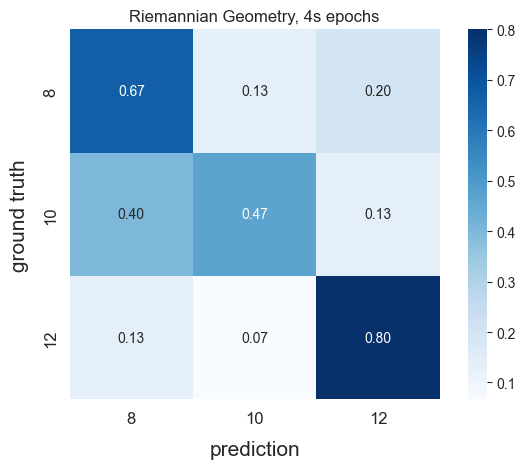

Accuracy=0.644+-0.140
95% Confidence Interval: (0.505 0.784)


(array([[10.,  2.,  3.],
        [ 6.,  7.,  2.],
        [ 2.,  1., 12.]]),
 0.6444444444444445,
 0.5045861233133887,
 0.7843027655755003)

In [23]:
Plotly().create_confusion_matrix(predicted_classes, actual_classes,gt_dict, plot=True, title = 'Riemannian Geometry, 4s epochs')